# 参考資料


[動作環境] Google colaboratory 

In [4]:
import featuretools as ft
import lightgbm as lgb
#import optuna
import numpy as np
import sklearn.datasets
import sklearn.metrics
import pandas as pd
import matplotlib.pyplot as plt
# import tensorflow as tf
import xgboost as xgb
import re
import seaborn as sns
# from tensorflow import keras
# import keras.layers as L
import seaborn as sns
from datetime import datetime, timezone, timedelta
from keras.models import Model
from sklearn.decomposition import PCA
from keras import losses
from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_log_error
import unicodedata

ModuleNotFoundError: No module named 'xgboost'

In [0]:
!pip install japanize-matplotlib
import japanize_matplotlib
!pip install jeraconv
from jeraconv import jeraconv

     |████████████████████████████████| 4.1MB 24kB/s 
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.1-cp36-none-any.whl size=4120191 sha256=88555cf8256f4daefec68583523e889cc5e23660465f1e9bbdfd5585c584ced5
  Stored in directory: /root/.cache/pip/wheels/c9/97/63/592117b7fd57075ad8942653fd47d7cc0d061311f88e89ab42
Successfully built japanize-matplotlib


/usr/local/lib/python3.6/dist-packages/japanize_matplotlib/japanize_matplotlib.py:15: MatplotlibDeprecationWarning: 
The createFontList function was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use FontManager.addfont instead.
  font_list = font_manager.createFontList(font_files)


# データの読み込み

In [0]:
train = pd.read_csv("train_data.csv")
print("train shape is " + str(train.shape))
train.head(1)

train shape is (19720, 17)


,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description,y
0,1,GDtyztIThRQ,[12] BGM Inazuma Eleven 3 - ~ライオコツト ダンジョン~,2011-01-09T05:50:33.000Z,UCQaNYC3dNvH8FqrEyK7hTJw,DjangoShiny,20,20.01.02,Inazuma|Eleven|Super|Once|bgm|ost|イナズマイレブン|Kyo...,114,0,7,https://i.ytimg.com/vi/GDtyztIThRQ/default.jpg,False,False,~ライオコツト ダンジョン~Inazuma Eleven 3 BGM Complete (R...,29229
1,2,m4H9s3GtTlQ,ねごと - メルシールー [Official Music Video],2012-07-23T03:00:09.000Z,UChMWDi-HBm5aS3jyRSaAWUA,ねごと Official Channel,10,20.08.02,ねごと|ネゴト|メルシールー|Re:myend|リマインド|Lightdentity|ライデ...,2885,50,111,https://i.ytimg.com/vi/m4H9s3GtTlQ/default.jpg,False,False,http://www.negoto.com/全員平成生まれ、蒼山幸子（Vo＆Key)、沙田瑞...,730280
2,3,z19zYZuLuEU,VF3tb 闇よだれvsちび太 (SEGA),2007-07-26T13:54:09.000Z,UCBdcyoZSt5HBLd_n6we-xIg,siropai,24,20.14.01,VF3|VF4|VF5|ちび太|闇よだれ|chibita|virtuafighter|seg...,133,17,14,https://i.ytimg.com/vi/z19zYZuLuEU/default.jpg,False,False,Beat-tribe cup finalhttp://ameblo.jp/siropai/,80667
3,4,pmcIOsL7s98,free frosty weekend!,2005-05-15T02:38:43.000Z,UC7K5am1UAQEsCRhzXpi9i1g,Jones4Carrie,22,19.22.12,frosty,287,51,173,https://i.ytimg.com/vi/pmcIOsL7s98/default.jpg,False,False,I look so bad but look at me!,34826
4,5,ZuQgsTcuM-4,トップ・オブ・ザ・ワールド,2007-09-09T09:52:47.000Z,UCTW1um4R-QWa8iIfITGvlZQ,Tatsuya Maruyama,10,20.08.01,ギター|guitar|南澤大介|トップオブザワールド|トップ|オブ|ワールド|カーペンターズ...,178,6,17,https://i.ytimg.com/vi/ZuQgsTcuM-4/default.jpg,False,False,ソロギターのしらべより「トップオブザワールド」です。クラシックギターで弾いてます。Offic...,172727
5,6,GivuDeAGhyk,ゲンム や スナイプ たちとのグリーティング 💛 仮面ライダーエグゼイドスペシャルショー に...,2017-01-11T00:34:20.000Z,UCWy5UcrxbfXg5IW47_ntAXQ,はれママ キッズTV,24,20.09.02,ゲンム|スナイプ|グリーティング|仮面ライダーエグゼイド|ジュウオウジャー|魔法学校の制服|...,0,0,53,https://i.ytimg.com/vi/GivuDeAGhyk/default.jpg,False,True,先日のよみうりランドで行われた「 仮面ライダーエグゼイドスペシャルショー」の時のグリーティン...,1358158
6,7,yiYr2-6LtcU,Juice=Juice『「ひとりで生きられそう」って それってねえ、褒めているの？』(Pro...,2019-05-24T08:00:11.000Z,UC6FadPgGviUcq6VQ0CEJqdQ,JuiceJuice,10,20.09.02,Juice=Juice|JuiceJuice|ジュースジュース|ジュース|ハロー！プロジェク...,36905,394,4066,https://i.ytimg.com/vi/yiYr2-6LtcU/default.jpg,False,False,2019年6月5日発売のJuice=Juice 12thシングル『「ひとりで生きられそう」っ...,2881014
7,8,TUPHOUN2T30,Yersiz7-5/8,2007-09-01T21:24:46.000Z,UC1zw3DnHyfaA88T8NSn0Upw,AcemCadi,15,20.08.01,5,5,3,0,https://i.ytimg.com/vi/TUPHOUN2T30/default.jpg,False,False,5,12711
8,9,kRCi9nxy-Uc,ドリフト専用 GT-R開発ストーリーⅡ ～進化するモンスターマシン 【本編】｜TOYO TIRES,2017-06-27T10:55:01.000Z,UCkW0S2pnXBY2R03jM5C-77Q,TOYO TIRES JAPAN,2,20.09.02,Drift|Drifting|Nissan GT-R|ドリフト|Team TOYO TIRE...,4638,300,439,https://i.ytimg.com/vi/kRCi9nxy-Uc/default.jpg,False,False,競技のためのドリフト走行のみを見据え、開発されたTeam TOYO TIRES DRIFTの...,1003949
9,10,G6s8HF1WsJY,BUMP OF CHICKEN「話がしたいよ」,2018-10-14T15:00:02.000Z,UCOfESRUR5duQ2hMnTQ4oqhA,BUMP OF CHICKEN,10,20.09.02,BUMP OF CHICKEN|億男,80206,1545,11012,https://i.ytimg.com/vi/G6s8HF1WsJY/default.jpg,False,False,BUMP OF CHICKEN「話がしたいよ」※映画『億男』主題歌2018.10.15 (m...,13039631


In [0]:
test = pd.read_csv("test_data.csv")
iddf = test[["id"]]
print("test shape is " + str(test.shape))
test.head(1)

test shape is (29582, 16)


,id,video_id,title,publishedAt,channelId,channelTitle,categoryId,collection_date,tags,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,1,xU8UcB6RbLE,Frightened Rabbit - The Greys,2007-09-26T11:00:07.000Z,UCOQ_j8Qg4-p0lGKBpXYENbg,Fatcat Records,10,20.08.01,Fatcat|Records|Frightened|Rabbit|The|Greys,471,38,61,https://i.ytimg.com/vi/xU8UcB6RbLE/default.jpg,False,False,Director: Fraser CampbellDate:2007Taken from F...


# 前処理

In [0]:
train = pd.read_csv("train_data.csv")
test = pd.read_csv("test_data.csv")

train["y"] = np.log(train["y"])

mean_ = train[["categoryId", "y"]].groupby("categoryId").mean().reset_index().rename({"y":"mean"}, axis=1)
max_ = train[["categoryId", "y"]].groupby("categoryId").max().reset_index().rename({"y":"max"}, axis=1)
min_ = train[["categoryId", "y"]].groupby("categoryId").min().reset_index().rename({"y":"min"}, axis=1)
std_ = train[["categoryId", "y"]].groupby("categoryId").std().reset_index().rename({"y":"std"}, axis=1)
count_ = train[["categoryId", "y"]].groupby("categoryId").count().reset_index().rename({"y":"count"}, axis=1)
q1_ = train[["categoryId", "y"]].groupby("categoryId").quantile(0.1).reset_index().rename({"y":"q1"}, axis=1)
q25_ = train[["categoryId", "y"]].groupby("categoryId").quantile(0.25).reset_index().rename({"y":"q25"}, axis=1)
q5_ = train[["categoryId", "y"]].groupby("categoryId").quantile(0.5).reset_index().rename({"y":"q5"}, axis=1)
q75_ = train[["categoryId", "y"]].groupby("categoryId").quantile(0.75).reset_index().rename({"y":"q75"}, axis=1)
q9_ = train[["categoryId", "y"]].groupby("categoryId").quantile(0.9).reset_index().rename({"y":"q9"}, axis=1)

def is_japanese(string):
    for ch in string:
        try:
            name = unicodedata.name(ch) 
            if "CJK UNIFIED" in name \
            or "HIRAGANA" in name \
            or "KATAKANA" in name:
                return True
        except:
          continue
    return False

y = train["y"]
del train["y"]

df = pd.concat([train, test])

df["tags"].fillna("[none]", inplace=True)
tagdic = dict(pd.Series("|".join(list(df["tags"])).split("|")).value_counts().sort_values())


def bool_to_int(df):
    df["comments_disabled"] = df["comments_disabled"].astype(np.int16)
    df["ratings_disabled"] = df["ratings_disabled"].astype(np.int16)
    return df

def create_features(df):
    # like dislike comment
    #df["likes2"] = df["likes"]**2
    df["loglikes"] = np.log(df["likes"]+1)
    #df["dislikes2"] = df["dislikes"]**2
    df["logdislikes"] = np.log(df["dislikes"]+1)
    df["logcomment_count"] = np.log(df["comment_count"]+1)
    df["sqrtlikes"] = np.sqrt(df["likes"])
    df["like_dislike_ratio"] = df["likes"]/(df["dislikes"]+1)
    df["comments_like_ratio"] = df["comment_count"]/(df["likes"]+1)
    df["comments_dislike_ratio"] = df["comment_count"]/(df["dislikes"]+1)

    # likes comments diable
    df["likes_com"] = df["likes"] * df["comments_disabled"]
    df["dislikes_com"] = df["dislikes"] * df["comments_disabled"]
    df["comments_likes"] = df["comment_count"] * df["ratings_disabled"]

    # tags
    df["num_tags"] = df["tags"].astype(str).apply(lambda x: len(x.split("|")))
    df["length_tags"] = df["tags"].astype(str).apply(lambda x: len(x))
    df["tags_point"] = df["tags"].apply(lambda tags: sum([tagdic[tag] for tag in tags.split("|")]))
    df["count_en_tag"] = df["tags"].apply(lambda x: sum([bool(re.search(r'[a-zA-Z0-9]', x_)) for x_ in x.split("|")]))
    df["count_ja_tag"] = df["tags"].apply(lambda x: sum([is_japanese(x_) for x_ in x.split("|")]))

    # publishedAt
    df["publishedAt"] = pd.to_datetime(df["publishedAt"], utc=True)
    df["publishedAt_year"] = df["publishedAt"].apply(lambda x: x.year)
    df["publishedAt_month"] = df["publishedAt"].apply(lambda x: x.month)
    df["publishedAt_day"] = df["publishedAt"].apply(lambda x: x.day)
    df["publishedAt_hour"] = df["publishedAt"].apply(lambda x: x.hour)
    df["publishedAt_minute"] = df["publishedAt"].apply(lambda x: x.minute)
    #df["publishedAt_second"] = df["publishedAt"].apply(lambda x: x.second)
    df["publishedAt_dayofweek"] = df["publishedAt"].apply(lambda x: x.dayofweek)

    # collection_date
    #df["collection_date_year"] = df["collection_date"].apply(lambda x: int(x[0:2]))
    df["collection_date_month"] = df["collection_date"].apply(lambda x: int(x[3:5]))
    df["collection_date_day"] = df["collection_date"].apply(lambda x: int(x[6:8]))
    df["collection_date"] = pd.to_datetime("20"+df["collection_date"], format="%Y.%d.%m", utc=True)

    # delta
    df["delta"] = (df["collection_date"] - df["publishedAt"]).apply(lambda x: x.days)
    df["logdelta"] = np.log(df["delta"])
    df["sqrtdelta"] = np.sqrt(df["delta"])
    df["published_delta"] = (df["publishedAt"] - df["publishedAt"].min()).apply(lambda x: x.days)
    df["collection_delta"] = (df["collection_date"] - df["collection_date"].min()).apply(lambda x: x.days)

    df["description"].fillna(" ", inplace=True)
    df["ishttp_in_dis"] = df["description"].apply(lambda x: x.lower().count("http"))
    df["len_description"] = df["description"].apply(lambda x: len(x))

    df["title"].fillna(" ", inplace=True)
    df["len_title"] = df["title"].apply(lambda x: len(x))

    # is japanese
    df["isJa_title"] = df["title"].apply(lambda x: is_japanese(x))
    df["isJa_tags"] = df["tags"].apply(lambda x: is_japanese(x))
    df["isJa_description"] = df["description"].apply(lambda x: is_japanese(x))

    # is englosh
    #df["onEn_title"] = df["title"].apply(lambda x: x.encode('utf-8').isalnum())
    df["onEn_tags"] = df["tags"].apply(lambda x: x.encode('utf-8').isalnum())
    df["onEn_description"] = df["description"].apply(lambda x: x.encode('utf-8').isalnum())

    # cotain englosh
    df["conEn_title"] = df["title"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
    df["conEn_tags"] = df["tags"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))
    df["conEn_description"] = df["description"].apply(lambda x: len(re.findall(r'[a-zA-Z0-9]', x.lower())))

    # Music
    df["music_title"] = df["title"].apply(lambda x: "music" in x.lower())
    df["music_tags"] = df["tags"].apply(lambda x: "music" in x.lower())
    df["music_description"] = df["description"].apply(lambda x: "music" in x.lower())

    # Official
    df["isOff"] = df["title"].apply(lambda x: "fficial" in x.lower())
    df["isOffChannell"] = df["channelTitle"].apply(lambda x: "fficial" in x.lower())
    df["isOffJa"] = df["title"].apply(lambda x: "公式" in x.lower())
    df["isOffChannellJa"] = df["channelTitle"].apply(lambda x: "公式" in x.lower())

    # Music
    df["cm_title"] = df["title"].apply(lambda x: "cm" in x.lower())
    df["cm_tags"] = df["tags"].apply(lambda x: "cm" in x.lower())
    df["cm_description"] = df["description"].apply(lambda x: "cm" in x.lower())


    df = df.merge(mean_, how='left', on=["categoryId"])
    df = df.merge(max_, how='left', on=["categoryId"])
    df = df.merge(min_, how='left', on=["categoryId"])
    df = df.merge(std_, how='left', on=["categoryId"])
    #df = df.merge(count_, how='left', on=["categoryId"])
    df = df.merge(q1_, how='left', on=["categoryId"])
    df = df.merge(q25_, how='left', on=["categoryId"])
    df = df.merge(q5_, how='left', on=["categoryId"])
    df = df.merge(q75_, how='left', on=["categoryId"])
    df = df.merge(q9_, how='left', on=["categoryId"])

    # 出現頻度
    for col in ["categoryId", "channelTitle"]:
    freq = df[col].value_counts()
    df["freq_"+col] = df[col].map(freq)

    return df

  #df['categoryId'] = df['categoryId'].astype('category')

df = bool_to_int(df)
df = create_features(df)

del df["channelId"]
del df["video_id"]
del df["title"]
del df["description"]
del df["thumbnail_link"]
del df["channelTitle"]
del df["tags"]
del df["publishedAt"]
del df["collection_date"]
del df["id"]

scalar = StandardScaler()
scalar.fit(df)
df = pd.DataFrame(scalar.transform(df), columns=df.columns)

X = df.iloc[:len(y), :]
test = df.iloc[len(y):, :]


# LGB

In [0]:
def rmsle(preds, data):
    y_true = data.get_label()
    y_pred = preds
    y_pred[y_pred<0] = 0
    y_true[y_true<0] = 0
    acc = np.sqrt(mean_squared_log_error(np.exp(y_true), np.exp(y_pred)))
    # name, result, is_higher_better
    return 'accuracy', acc, False

Fold : 0
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.415821	valid's rmse: 0.791254
[1000]	train's rmse: 0.272764	valid's rmse: 0.780818
[1500]	train's rmse: 0.191684	valid's rmse: 0.77976
Early stopping, best iteration is:
[1802]	train's rmse: 0.156017	valid's rmse: 0.779337
[0]	train-rmse:12.0564	eval-rmse:12.0558
Multiple eval metrics have been passed: 'eval-rmse' will be used for early stopping.

Will train until eval-rmse hasn't improved in 100 rounds.
[500]	train-rmse:0.663573	eval-rmse:0.802208
[1000]	train-rmse:0.562327	eval-rmse:0.78955
[1500]	train-rmse:0.489989	eval-rmse:0.781737
Stopping. Best iteration:
[1605]	train-rmse:0.476654	eval-rmse:0.781063

best_rmsle= 0.7723708735179381
best_alpha= 0.53
Fold : 1
Training until validation scores don't improve for 100 rounds.
[500]	train's rmse: 0.415948	valid's rmse: 0.806761
[1000]	train's rmse: 0.274257	valid's rmse: 0.796092
[1500]	train's rmse: 0.19296	valid's rmse: 0.793606
Early stoppi

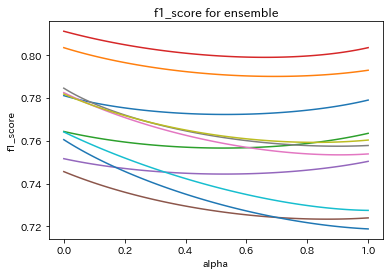

In [0]:
# Optunaの最適化パラメータを代入する
light_params = {'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        "seed":42,
        'learning_rate': 0.01,}
best_params =  {'lambda_l1': 0.019918875912078603, 'lambda_l2': 0.002616688073257713, 'num_leaves': 219, 'feature_fraction': 0.6641013611124621, 'bagging_fraction': 0.7024199018549259, 'bagging_freq': 5, 'min_child_samples': 5}
#best_params =  {}
light_params.update(best_params)

xgb_params = {'learning_rate': 0.1,
              'objective': 'reg:squarederror',
              'eval_metric': 'rmse',
              'seed': 42,
              'tree_method': 'hist'}
best_params = {'learning_rate': 0.01665914389764044, 'lambda_l1': 4.406831762257336, 'num_leaves': 39}
#best_params = {}
xgb_params.update(best_params)


FOLD_NUM = 11
kf = KFold(n_splits=FOLD_NUM,
           shuffle=True,
           random_state=42)
scores = []
feature_importance_df = pd.DataFrame()

pred_cv = np.zeros(len(test.index))
num_round = 10000


for i, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'Fold : {i}')
    ######LGB
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.values[tdx], y.values[vdx]

    # LGB
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_valid = lgb.Dataset(X_valid, y_valid)
    gbc = lgb.train(light_params, lgb_train, num_boost_round=num_round,
                  valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                  #feval=rmsle,
                  early_stopping_rounds=100, verbose_eval=500)
    if i ==0:
        importance_df = pd.DataFrame(gbc.feature_importance(), index=X.columns, columns=['importance'])
    else:
        importance_df += pd.DataFrame(gbc.feature_importance(), index=X.columns, columns=['importance'])
    gbc_va_pred = np.exp(gbc.predict(X_valid, num_iteration=gbc.best_iteration))
    gbc_va_pred[gbc_va_pred<0] = 0

    # XGB
    xgb_dataset = xgb.DMatrix(X_train, label=y_train)
    xgb_test_dataset = xgb.DMatrix(X_valid, label=y_valid)
    xgbm = xgb.train(xgb_params, xgb_dataset, 10000, evals=[(xgb_dataset, 'train'),(xgb_test_dataset, 'eval')],
                      early_stopping_rounds=100, verbose_eval=500)
    xgbm_va_pred = np.exp(xgbm.predict(xgb.DMatrix(X_valid)))
    xgbm_va_pred[xgbm_va_pred<0] = 0
    

    # ENS
    # lists for keep results
    lgb_xgb_rmsle = []
    lgb_xgb_alphas = []

    for alpha in np.linspace(0,1,101):
        y_pred = alpha*gbc_va_pred + (1 - alpha)*xgbm_va_pred
        rmsle_score = np.sqrt(mean_squared_log_error(np.exp(y_valid), y_pred))
        lgb_xgb_rmsle.append(rmsle_score)
        lgb_xgb_alphas.append(alpha)
    
    lgb_xgb_rmsle = np.array(lgb_xgb_rmsle)
    lgb_xgb_alphas = np.array(lgb_xgb_alphas)

    lgb_xgb_best_alpha = lgb_xgb_alphas[np.argmin(lgb_xgb_rmsle)]

    print('best_rmsle=', lgb_xgb_rmsle.min())
    print('best_alpha=', lgb_xgb_best_alpha)
    plt.plot(lgb_xgb_alphas, lgb_xgb_rmsle)
    plt.title('f1_score for ensemble')
    plt.xlabel('alpha')
    plt.ylabel('f1_score')

    score_ = lgb_xgb_rmsle.min()
    scores.append(score_)

    lgb_submission = np.exp(gbc.predict((test), num_iteration=gbc.best_iteration))
    lgb_submission[lgb_submission<0] = 0

    xgbm_submission = np.exp(xgbm.predict(xgb.DMatrix(test)))
    xgbm_submission[xgbm_submission<0] = 0

    submission = lgb_xgb_best_alpha*lgb_submission + (1 - lgb_xgb_best_alpha)*xgbm_submission

    pred_cv += submission/FOLD_NUM

print("##########")
print(np.mean(scores))

In [0]:
# 0.765394813186907
pd.set_option('display.max_rows', None)
importance_df.sort_values("importance")

,importance
onEn_description,806
onEn_tags,1250
comments_likes,2150
cm_tags,2190
isOffJa,2496
music_title,2685
isOffChannell,2805
isOff,3193
isJa_tags,3296
cm_title,3534


In [0]:
light_submission_df = pd.concat([iddf, pd.DataFrame(pred_cv)], axis=1)
light_submission_df.columns = ["id", "y"]
light_submission_df.to_csv("submission_lgb.csv", index=False)
print("end")

end


# 以下、試行錯誤

In [0]:
from keras import losses
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers.convolutional import Conv1D, UpSampling1D
from keras.layers.pooling import MaxPool1D
from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling1D
from keras.callbacks import LearningRateScheduler
from sklearn.preprocessing import OneHotEncoder
from keras.optimizers import Adam

# 学習率
def step_decay(epoch):
    x = 0.01
    if epoch >= 120: x = 0.001
    return x
lr_decay = LearningRateScheduler(step_decay)

# Optunaの最適化パラメータを代入する
def create_mlp(shape):
    '''
    Returns a keras model
    '''
    print(f"shape: {shape}")
    model = Sequential()
    model.add(Conv1D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=shape))
    model.add(BatchNormalization())
    model.add(Conv1D(32, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.2))
    model.add(Conv1D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(64, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.3))
    model.add(Conv1D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(Conv1D(128, 3, activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1))
    return model


FOLD_NUM = 4
kf = KFold(n_splits=FOLD_NUM,
           shuffle=True,
           random_state=42)
scores = []
feature_importance_df = pd.DataFrame()

pred_cv = np.zeros(len(test.index))


for i, (tdx, vdx) in enumerate(kf.split(X, y)):
    print(f'Fold : {i}')
    X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.values[tdx], y.values[vdx]

    mlp = create_mlp((X_train.values.shape[1], 1))
    optimizer = Adam(lr=0.001)
    mlp.compile(optimizer=optimizer, loss=losses.mean_squared_error)
    mlp.fit(x=np.reshape(X_train.values, (-1, X_train.shape[1], 1)), y=y_train.reshape(len(y_train),1),
           epochs=150, batch_size=493,
           validation_data=(np.reshape(X_valid.values, (-1, X_valid.shape[1], 1)), y_valid),
            callbacks=[lr_decay])#, verbose=0)

    mlp_pred = mlp.predict(np.reshape(X_valid.values, (-1, X_train.shape[1], 1)))

    plt.plot(mlp.history.history['loss'][3:], 'r', label='loss', alpha=0.7)
    plt.plot(mlp.history.history['val_loss'][3:], label='val_loss', alpha=0.7)
    plt.show()

    rmsle_score = np.sqrt(mean_squared_log_error(np.exp(y_valid), np.exp(mlp_pred)))
    print(rmsle_score)

    break


In [0]:
# memo
#Epoch 230/400
#14790/14790 [==============================] - 4s 301us/step - loss: 1.9379 - val_loss: 0.7369
np.sqrt(mean_squared_log_error(np.exp(y_valid), np.exp(mlp_pred)))

In [0]:
!pip install optuna
import optuna

# OptunaLightGBM

In [0]:
def objective(trial):
    params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'regression',
        'metric': 'rmse',
        'verbosity': -1,
        "seed":42,
        "learning_rate":trial.suggest_loguniform('learning_rate', 0.005, 0.03),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    FOLD_NUM = 4
    kf = KFold(n_splits=FOLD_NUM,
              #shuffle=True,
              random_state=42)
    scores = []
    feature_importance_df = pd.DataFrame()

    pred_cv = np.zeros(len(test.index))
    num_round = 10000


    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.values[tdx], y.values[vdx]
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_valid = lgb.Dataset(X_valid, y_valid)
        model = lgb.train(params, lgb_train, num_boost_round=num_round,
                      valid_names=["train", "valid"], valid_sets=[lgb_train, lgb_valid],
                      early_stopping_rounds=10, verbose_eval=10000)
        va_pred = model.predict(X_valid)
        score_ = np.sqrt(mean_squared_error(y_valid, va_pred))
        scores.append(score_)

    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 結果の確認
print('Best trial:')
light_trial = study.best_trial

print('  Value: {}'.format(light_trial.value))

print('  Params: ')

with open("lightgbmparams.txt", "w") as file:
    for key, value in light_trial.params.items():
       print('    "{}": {},'.format(key, value))
       file.write('"{}": {},'.format(key, value))


In [0]:
#0.7894605792171627

# Xgboost Optuna

In [0]:

def objective(trial):
    params = {
        'objective': 'reg:squarederror',
        'eval_metric': 'rmse',
        'seed': 42,
        'tree_method': 'hist',
        "learning_rate":trial.suggest_loguniform('learning_rate', 0.005, 0.03),
        'lambda_': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        #'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        #'feature_fraction': trial.suggest_uniform('feature_fraction', 0.4, 1.0),
        #'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.4, 1.0),
        #'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        #'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
    }
    FOLD_NUM = 4
    kf = KFold(n_splits=FOLD_NUM,
              #shuffle=True,
              random_state=42)
    scores = []
    feature_importance_df = pd.DataFrame()

    pred_cv = np.zeros(len(test.index))
    num_round = 10000


    for i, (tdx, vdx) in enumerate(kf.split(X, y)):
        print(f'Fold : {i}')
        X_train, X_valid, y_train, y_valid = X.iloc[tdx], X.iloc[vdx], y.values[tdx], y.values[vdx]
        # XGB
        xgb_dataset = xgb.DMatrix(X_train, label=y_train)
        xgb_test_dataset = xgb.DMatrix(X_valid, label=y_valid)
        xgbm = xgb.train(params, xgb_dataset, 10000, evals=[(xgb_dataset, 'train'),(xgb_test_dataset, 'eval')],
                          early_stopping_rounds=100, verbose_eval=5000)
        xgbm_va_pred = xgbm.predict(xgb.DMatrix(X_valid))
        xgbm_va_pred[xgbm_va_pred<0] = 0
        score_ = np.sqrt(mean_squared_error(y_valid, xgbm_va_pred))
        scores.append(score_)

    return np.mean(scores)

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

# 結果の確認
print('Best trial:')
light_trial = study.best_trial

print('  Value: {}'.format(light_trial.value))

print('  Params: ')

with open("lightgbmparams.txt", "w") as file:
    for key, value in light_trial.params.items():
       print('    "{}": {},'.format(key, value))
       file.write('"{}": {},'.format(key, value))


In [0]:
#non turning params 0.7897379694106698